In [1]:
# built-in
import os
from datetime import datetime

from dataclasses import dataclass
from typing import Dict, List, Tuple, Union, Callable, Optional
from enum import Enum


# 3rd party lib
import pandas as pd
import numpy as np
import yaml

import matplotlib.pyplot as plt

from scipy import signal

# ros:
import rosbag

# 3rd party util
from icecream import ic

In [2]:
# ours:
from uwarl_helper.uwarl_util import create_all_folders
from uwarl_bag_utils.bag_parser import BagParser, TYPES_VAR

from src.uwarl_plot import Color_Wheel, COLOR_TABLE_1, CMAP_Selector, HandlerColormap, get_color_table
from src.uwarl_common import PARSER_CALLBACKS

In [3]:
BP = BagParser(PARSER_CALLBACKS)

# 1. Pre-Config 

In [4]:
DIRECTORY = "/home/jx/.ros/bag_replay_recorder_files"
BAG_DICT = {
    "EE1-RVR-Pt-L/R": "EE-1-8_S5-E30_8_DEMO_23_recording_2023-04-06-16-18-37_2023-04-11-11-25-29.bag",
    "EE1-FWD-Pt-U/D": "EE-1-9_S5-E30_9_DEMO_18_recording_2023-04-06-16-19-17_2023-04-11-11-26-32.bag",
    "EE1-RVR-Pt-U/D": "EE-1-10_S5-E30_10_DEMO_24_recording_2023-04-06-16-20-02_2023-04-11-11-27-38.bag",
}

FIG_OUT_DIR = "/home/jx/UWARL_catkin_ws/src/vins-research-pkg/research-project/output/vins_analysis"

class AnalysisManager:
    """ Analysis Manager 
        - handle global settings and keep consistency
        - manage output folder
    """
    _auto_save :bool = True
    _auto_close :bool = False # Turn on to close all figures after saving
    _output_dir :str = FIG_OUT_DIR
    _bag_dict :Dict[str, str] = BAG_DICT
    
    def __init__(self, output_dir: str=FIG_OUT_DIR, bag_dict: Dict[str, str]=BAG_DICT, run_name: str="vins_analysis"):
        # create output folder
        self._create_dir(output_dir, run_name)
        # save info
        self._save_info(bag_dict=bag_dict)
    
    def _create_dir(self, output_dir: str, run_name: str):
        self._output_dir = f"{output_dir}/{run_name}"
        create_all_folders(self._output_dir)

    def _save_info(self, bag_dict: Dict[str, str]):
        self.save_dict(bag_dict, "info")
            
    def save_fig(self, fig, tag):
        if self._auto_save:
            fig.savefig(f"{self._output_dir}/plot_{tag.replace(' ', '_')}.png", bbox_inches = 'tight')
        if self._auto_close:
            plt.close(fig)
    
    def save_dict(self, data, file_name):
        if self._auto_save:
            with open(f"{self._output_dir}/{file_name}.yaml", "w") as f:
                yaml.dump(data, f)

AM = AnalysisManager(run_name="run_{}".format(datetime.now().strftime("%Y-%m-%d")))

[uwarl_util] creating folder: /home/jx/UWARL_catkin_ws/src/vins-research-pkg/research-project/output/vins_analysis/run_2023-04-12


# 2. Data Pre-Processing

In [5]:
# Processed Data Object Placeholder
class ProcessedData:
    """ Placeholder for processed data
        - bag files will be loaded with BagParser and processed in batch
        - processed data will be cached in this class
    """
    _bag_path: str=""
    bag_info: Dict[str, Union[str, float]] = {}
    bag_topics: Dict[str, List[str]] = {}
    bag_data: Dict[str, Union[str, float]] = {}
    bag_samples: Dict[str, Union[str, float]] = {}
    T0: float = 0.0
    T1: float = 0.0
    dT: float = 0.0
    description: Dict[str, Union[str, float]] = {}

    def __init__(self, DIRECTORY, BAG_PATH):
        self._bag_path = BAG_PATH
        # load bag file:
        BP.bind_bagfile(bagfile=f"{DIRECTORY}/{BAG_PATH}")
        BP.load_bag_topics()
        self.bag_info = BP.get_bag_info_safe()
        self.bag_topics = BP.get_bag_topics_lut_safe()
        BP.process_all_bag_msgs()
        self.bag_data = BP.get_processed_bag_safe()
        self.bag_samples = BP.get_bag_samples_safe()
        # self._bag = BP._bag_data # DEBUG: debug purpose
        # unbind toolchain
        BP.unbind_bagfile()
        self._init_process()
    
    def _init_process(self):
        self.T0=datetime.fromtimestamp(self.bag_info["start"])
        self.T1=datetime.fromtimestamp(self.bag_info["end"])
        self.dT = (self.T1 - self.T0).total_seconds()
        
        prefix = self._bag_path.split("_recording_")[0]
        ic(prefix)
        unique_id, t_window, run_id, _, demo_id = prefix.split("_")
        
        self.description = {
            "cam-session-run": unique_id,
            "dt": t_window,
            "demo": demo_id,
        }
        ic(self.description)

# 1. Process and Aggregate data from multiple bags:
pData={}
for label, path in AM._bag_dict.items():
    pData[label] = ProcessedData(DIRECTORY, path)
        

/home/jx/UWARL_catkin_ws/src/waterloo_steel/waterloo_steel_demo/waterloo_steel_analyzer/src/uwarl_bag_utils/bag_parser.py:106: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  self._info_dict = yaml.load(self._bag_data._get_yaml_info())
ic| prefix: 'EE-1-8_S5-E30_8_DEMO_23'
ic| self.description: {'cam-session-run': 'EE-1-8', 'demo': '23', 'dt': 'S5-E30'}
ic| prefix: 'EE-1-9_S5-E30_9_DEMO_18'
ic| self.description: {'cam-session-run': 'EE-1-9', 'demo': '18', 'dt': 'S5-E30'}
ic| prefix: 'EE-1-10_S5-E30_10_DEMO_24'
ic| self.description: {'cam-session-run': 'EE-1-10', 'demo': '24', 'dt': 'S5-E30'}


In [6]:
# DEBUG: save a sample here:
pD = pData["EE1-RVR-Pt-U/D"]
AM.save_dict(pD.bag_samples, "bag_samples")

# 3. Plotting Multiple datasets from multiple bagfiles

In [7]:
## Generic Handy Multi-Segments Multi-Topical Plotting Functions:
CWheel = Color_Wheel(get_color_table("tab10", 10))

def plot_data_sets_along_xaxis(data_sets_xy, xlabel="", PAD_WIDTH=0.1, figsize=(10,5)):
    fig, ax = plt.subplots(figsize=figsize)
    
    N_size = len(data_sets_xy)
    axes = [ax if i==0 else ax.twinx() for i in range(N_size)] # twin x-axis 
    fig.subplots_adjust(right=(1-N_size*PAD_WIDTH)) 
    
    for i in range(1,N_size):
        axes[i].spines["right"].set_position(("axes", 1+(i-1)*PAD_WIDTH))
    
    if N_size > 1:
        axes[-1].set_frame_on(True)
        axes[-1].patch.set_visible(False)

    # plotting:
    for i, (label, data) in enumerate(data_sets_xy.items()):
        axes[i].plot(data["x"], data["y"], color=CWheel[i], label=label)
        axes[i].set_ylabel(label, color=CWheel[i])
        # axes[i].set_ylim(bottom=np.min(data["y"]), top=np.max(data["y"]))
        axes[i].tick_params(axis='y', labelcolor=CWheel[i], colors=CWheel[i])
    
    axes[0].set_xlabel(xlabel)
    return fig, ax

def plot_data_sets_subplots(data_sets_xys, xlabel="", figsize=(5, 5)):
    """ Plot multiple data sets on subplots, with different bag files on the same subplot.
    """
    N_sets = len(data_sets_y)
    fig, axs = plt.subplots(N_sets, figsize=(figsize[0], figsize[1]*N_sets/2))
    axs[-1].set_xlabel(xlabel)
    for j, (label, data) in enumerate(data_sets_xys.items()):
        for i, (_x,_y,_label)  in enumerate(zip(data["x"], data["y"], data["label"])):
            axs[j].set_ylabel(_label)
            axs[j].plot(_x, _y, label=_label, color=CWheel[i])
        axs[j].legend()
    return fig, axs


In [8]:
class Bags_Data_Plot:
    DEFAULT_FIGSIZE = (5, 5)
    # list of data placeholder:
    list_of_bags = []
    list_of_note = []
    list_of_dT_s = []
    list_of_bag_labels = []
    # list_of_battery_v = []
    # list_of_joint_eff = []
    N_bags = 0
    NAME: str = None
    
    def __init__(self, bags: Dict[str, ProcessedData]): 
        """ Re-organize data from multiple bag files into a single object.
        """
        for label, data in bags.items():
            self.N_bags += 1
            self.list_of_bags.append(data)
            self.list_of_bag_labels.append(label)
            self.list_of_note.append(data.description)
            self.list_of_dT_s.append(data.dT)
            
    
    def extract_data(self, pre_process_func=lambda x: x, bag_topic:str=None, var_type:TYPES_VAR=None):
        """ Extract data from multiple bag files and concatenate them into a single array.
        
            # data.bag_data["/uwarl/robotnik_base_hw/voltage"][TYPES_VAR.VOLTAGE]
            # np.linalg.norm(data.bag_data["/wam/joint_states"][TYPES_VAR.JOINT_EFFORT], axis=1)       
        """
        _payload = []
        for i in range(self.N_bags):
            _data = pre_process_func(self.list_of_bags[i].bag_data[bag_topic][var_type])     
            _payload.append(_data)
        return _payload
    
    def plot_time_series(self, data_sets_y, title="", if_label_bags=True, figsize=DEFAULT_FIGSIZE):
        """
        data_sets_y = {
            "Voltage (V)"       : battery_v,
            "Joint Effort (N.m)": joint_eff,
        }
        """
        N_bags = self.N_bags
        # concatenate all the data:
        dT_s = np.sum(self.list_of_dT_s)
        data_sets_xy = dict()
        for label, data in data_sets_y.items():
            data_sets_xy[label] = dict()
            data_sets_xy[label]["y"] = np.concatenate(data)
            data_sets_xy[label]["x"] = np.arange(0, dT_s, dT_s/len(data_sets_xy[label]["y"]))
                    
        # figure:
        _fig_size =(figsize[0]*N_bags, figsize[1])
        fig, _ = plot_data_sets_along_xaxis(data_sets_xy, xlabel="Time (s)", figsize=_fig_size)
        # plot labels:
        plt.title(f"{title} ({N_bags} bags)")
        
        # (Auto-label) Segment bag files:
        if if_label_bags:
            t_end = 0
            y_range = plt.ylim()
            # if N_bags > 1:
            plt.axvline(x=0, color = 'r', ls='--', alpha=0.5)
            for i in range(N_bags):
                # segment bag_files
                t_end += self.list_of_dT_s[i]
                label = self.list_of_bag_labels[i]
                plt.axvline(x=t_end, color = 'r', ls='--', alpha=0.5)
                plt.text(t_end, y_range[1], f" [{label}]", color='r', verticalalignment='top', horizontalalignment='right')
        
        AM.save_fig(fig, f"{title}_time_series.png")

    def plot_time_parallel(self, data_sets_y, title="", figsize=DEFAULT_FIGSIZE):
        """
        data_sets_y = {
            "Voltage (V)"       : battery_v,
            "Joint Effort (N.m)": joint_eff,
        }
        """
        data_sets_xys = dict()
        for label, data in data_sets_y.items():
            data_sets_xys[label] = dict()
            data_sets_xys[label]["y"] = data
            data_sets_xys[label]["x"] = [np.arange(0, dT_s, dT_s/len(y))[0:len(y)] for y, dT_s in zip(data, self.list_of_dT_s)]
            data_sets_xys[label]["label"] = self.list_of_bag_labels
            
        fig, ax = plot_data_sets_subplots(data_sets_xys, xlabel="Time (s)", figsize=figsize)
        ax[0].set_title(f"{title} ({self.N_bags} bags)")
        AM.save_fig(fig, f"{title}_time_parallel.png")
    
    

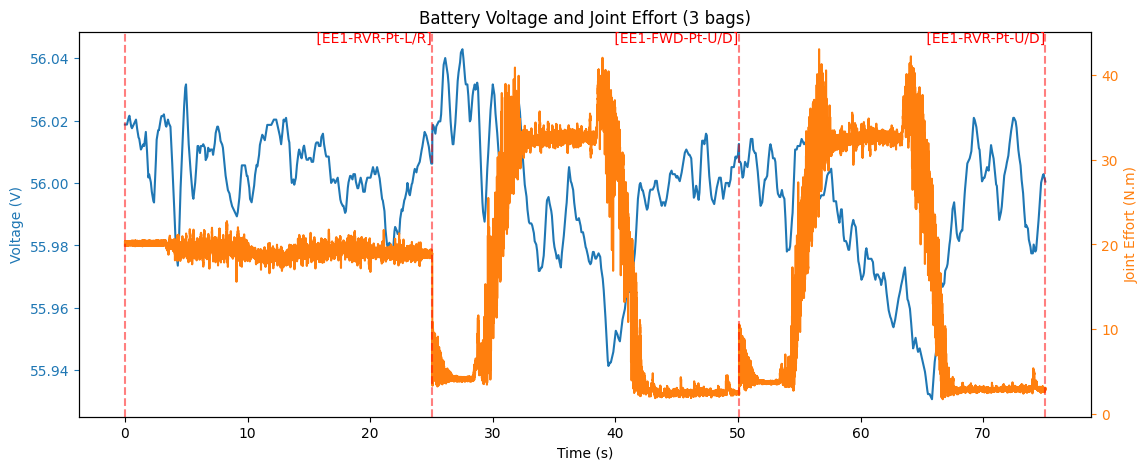

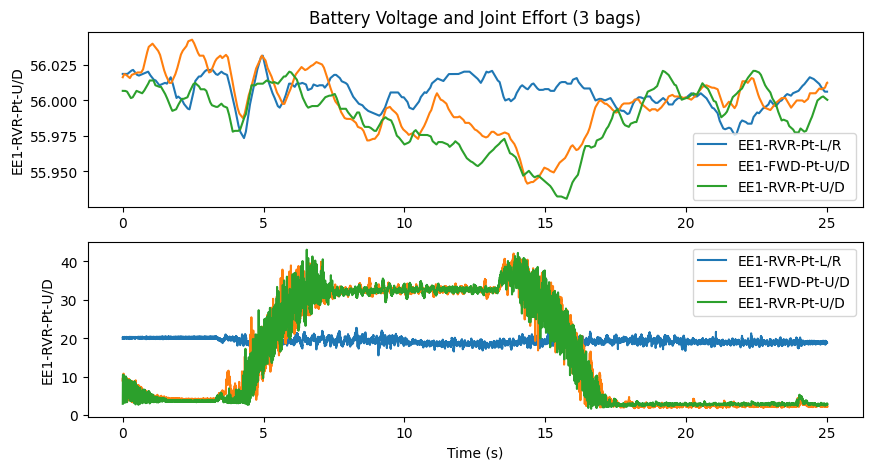

In [9]:
# 2. Load into data plotter:
BagPlot = Bags_Data_Plot(pData)

# 3. assemble data sets:
data_sets_y = {
    "Voltage (V)"       : BagPlot.extract_data(
        bag_topic="/uwarl/robotnik_base_hw/voltage", var_type=TYPES_VAR.VOLTAGE),
    "Joint Effort (N.m)": BagPlot.extract_data(
        bag_topic="/wam/joint_states", var_type=TYPES_VAR.JOINT_EFFORT, 
        pre_process_func=lambda x: np.linalg.norm(x, axis=1)),
}

# 4. Plot:
BagPlot.plot_time_series(data_sets_y, title="Battery Voltage and Joint Effort")
BagPlot.plot_time_parallel(data_sets_y, title="Battery Voltage and Joint Effort", figsize=(10,5))

